<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import nan, linspace, min, max, ravel, mean
from pandas import DataFrame, read_csv, concat
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from gc import collect
from pickle import dump
from IPython.display import clear_output
clear_output()

In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              low_memory=True,)

keep_cols = ['long', 
             'lat',
             'MID_POINT_X',]

df = df.loc[:, keep_cols]
data = create_table(df.head())
data.show()

In [ ]:
del data
collect()

41484

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',},
          inplace=True,)

ren = create_table(df.head())
ren.show()

keep_cols = ['long', 
             'lat',
             'MPX',]

In [ ]:
del ren
collect()

17255

In [ ]:
print(df.columns.values)

['long' 'lat' 'MPX']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19072

In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                       axis=0, # Adds dataframes in row
                       join='outer',) # Returns columns in both df1 and df2

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['MPX'].notnull().all()
assert df['long'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


long   NaN
lat    NaN
MPX    NaN
dtype: float64

In [ ]:
df.drop_duplicates(keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5,
               how='all',
               axis=1,)

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   long    18 non-null     float64
 1   lat     18 non-null     float64
 2   MPX     18 non-null     float64
dtypes: float64(3)
memory usage: 560.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Coo-Midpoint Report',
                        explorative=True,
                        progress_bar=True,)
profile.to_notebook_iframe()

In [ ]:
del profile
collect()

58650

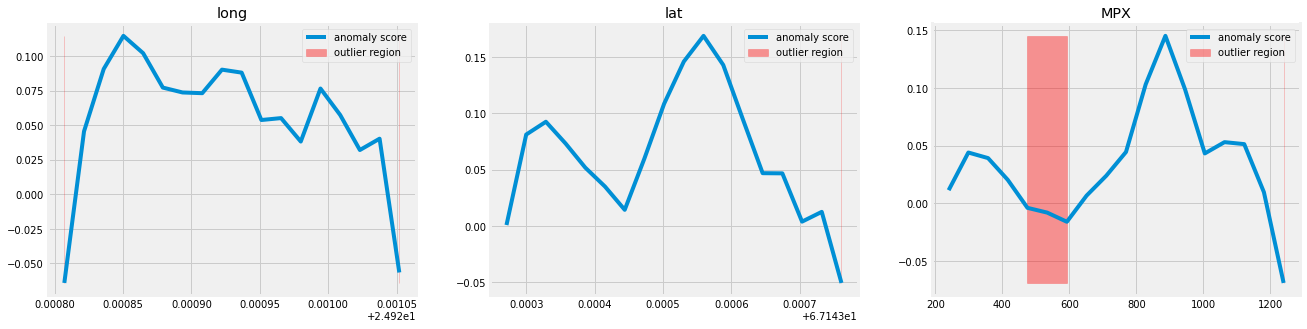

In [ ]:
cols = keep_cols
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)
fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1)
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1))

    xx = linspace(df[column].min(),
                  df[column].max(),
                  len(df)).reshape(-1, 1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score),
                        max(anomaly_score), 
                        where=outlier==-1,
                        color='r', 
                        alpha=.4,
                        label='outlier region',)
    axs[i].legend(frameon=True)
    axs[i].set_title(column)

In [ ]:
any(df.long <= 0)

False

In [ ]:
any(df.lat <= 0)

False

In [ ]:
any(df.MPX <= 0)

False

In [ ]:
X = df[['long',
        'lat',]]

y = df['MPX'].to_numpy().reshape(-1, 1)

In [ ]:
imp = KNNImputer(missing_values=nan,
                 n_neighbors=5,
                 weights='distance',
                 metric='nan_euclidean',)

In [ ]:
dump(imp,
     open('imp.pkl', 'wb'))

In [ ]:
regr = CatBoostRegressor(n_estimators=4000)

In [ ]:
dump(regr,
     open('catboost.pkl', 'wb'))

In [ ]:
pipeline = Pipeline(steps=[('i', imp),
                           ('r', regr),])
pipeline.fit(X, y.ravel(),)

Learning rate set to 0.006657
0:	learn: 326.8053165	total: 46.7ms	remaining: 3m 6s
1:	learn: 325.7733010	total: 47.3ms	remaining: 1m 34s
2:	learn: 324.9418156	total: 47.8ms	remaining: 1m 3s
3:	learn: 324.2301396	total: 48.1ms	remaining: 48s
4:	learn: 323.5576257	total: 48.3ms	remaining: 38.6s
5:	learn: 322.6212966	total: 48.6ms	remaining: 32.4s
6:	learn: 321.7122370	total: 49ms	remaining: 27.9s
7:	learn: 320.8720992	total: 49.3ms	remaining: 24.6s
8:	learn: 320.3212679	total: 49.7ms	remaining: 22.1s
9:	learn: 319.6413870	total: 50ms	remaining: 19.9s
10:	learn: 318.7921446	total: 50.1ms	remaining: 18.2s
11:	learn: 318.1571851	total: 50.3ms	remaining: 16.7s
12:	learn: 317.3730772	total: 50.6ms	remaining: 15.5s
13:	learn: 316.5844347	total: 50.8ms	remaining: 14.5s
14:	learn: 315.9249458	total: 51.2ms	remaining: 13.6s
15:	learn: 315.4961357	total: 51.7ms	remaining: 12.9s
16:	learn: 314.8943611	total: 52ms	remaining: 12.2s
17:	learn: 313.8925997	total: 52.3ms	remaining: 11.6s
18:	learn: 313.

Pipeline(memory=None,
         steps=[('i',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('r',
                 <catboost.core.CatBoostRegressor object at 0x7fbb01549198>)],
         verbose=False)

In [ ]:
scores = cross_val_score(regr,
                         X, y.ravel(),
                         cv=18,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[-327.04862992 -154.69091026 -226.71030257  -88.90211388 -113.80776819
 -426.72883063  -80.74790534 -156.10223819 -181.29869997  -38.39520614
 -266.93716154 -147.92181056  -25.59883462 -114.76814514  -52.40629548
  -88.82126286  -87.6666879   -75.13823018]


In [ ]:
print('RMSE: %2f' % (-1 * scores.mean()))

RMSE: 147.427280
